In [1]:
from scipy.stats import qmc
import numpy as np
import xarray as xr
import csv
import pandas as pd
import os
import netCDF4 as nc4
import sys
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                     
import shutil                                                                                                                                                       
import tempfile 
import random
import math

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm

import functions_py.fates_xarray_functions as fa

dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))
colormap[10] = colormap[11]

def clllpf_to_cn_lf_by_pft(clllpf_var, dataset, dataset2):
    """function to reshape a fates multiplexed canopy layer, leaf layer and pft-indexed variable to one indexed by canopy layer leaf layer and pft
    first argument should be an xarray DataArray that has the FATES CLLLPF dimension
    second argument should be an xarray Dataset that has the FATES CLLL dimensions
    (possibly the dataset encompassing the dataarray being transformed)
    returns an Xarray DataArray with the cnlf  (CLLL) and pft dimensions disentangled"""
    n_cnlf = len(dataset.fates_levcnlf)
    ds_out = (clllpf_var.rolling(fates_levcnlfpf=n_cnlf, center=False)
            .construct("fates_levcnlf")
            .isel(fates_levcnlfpf=slice(n_cnlf-1, None, n_cnlf))
            .rename({'fates_levcnlfpf':'fates_levpft'})
            .assign_coords({'fates_levcnlf':dataset.fates_levcnlf})
            .assign_coords({'fates_levpft':dataset.fates_levpft}))
    ds_out.attrs['long_name'] = clllpf_var.attrs['long_name']
    ds_out.attrs['units'] = clllpf_var.attrs['units']
    
    # now create a new dimension - leaf layers - and disentangle canopy layers and leaf layers
    n_levleaf = len(dataset2.fates_levleaf)
    ds_out2 = (ds_out.rolling(fates_levcnlf=n_levleaf, center=False)
               .construct("fates_levleaf")
               .isel(fates_levcnlf=slice(n_levleaf-1, None, n_levleaf))
               .rename({'fates_levcnlf':'fates_levcan'})
               .assign_coords({'fates_levleaf':dataset2.fates_levleaf})
               .assign_coords({'fates_levcan':dataset.fates_levcan}))
    ds_out2.attrs['long_name'] = ds_out.attrs['long_name']
    ds_out2.attrs['units'] = ds_out.attrs['units']
    
    return(ds_out2)

/var/folders/30/fzgs75l559g5v3hbrhqnl3kr0000gq/T/ipykernel_93396/2146082838.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  dark = cm.get_cmap('Paired', 12)


In [22]:
bcie = '/Users/sharmiladey/Desktop/bci_trendy_ensemble_2pfts.Eb645be3aa2-F14b1791a.2023-06-22.h0.ensemble.sofar.nc'
bcie = xr.open_dataset(bcie, decode_times=False)
bcietime = bcie.variables['time'] / 365
print(bcietime)
#print(bcie.data_vars)

<xarray.Variable (time: 141)>
array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140.],
      dtype=float32)


<xarray.DataArray 'FATES_VEGC_PF' (lndgrid: 1, time: 10)>
array([[0.99892145, 0.9839777 , 0.9752844 , 0.97694653, 0.98733443,
        0.98813236, 0.98560244, 0.9836828 , 0.98761487, 0.9796733 ]],
      dtype=float32)
Coordinates:
    fates_levpft  int32 1
  * time          (time) float32 4.782e+04 4.818e+04 ... 5.074e+04 5.11e+04
Dimensions without coordinates: lndgrid


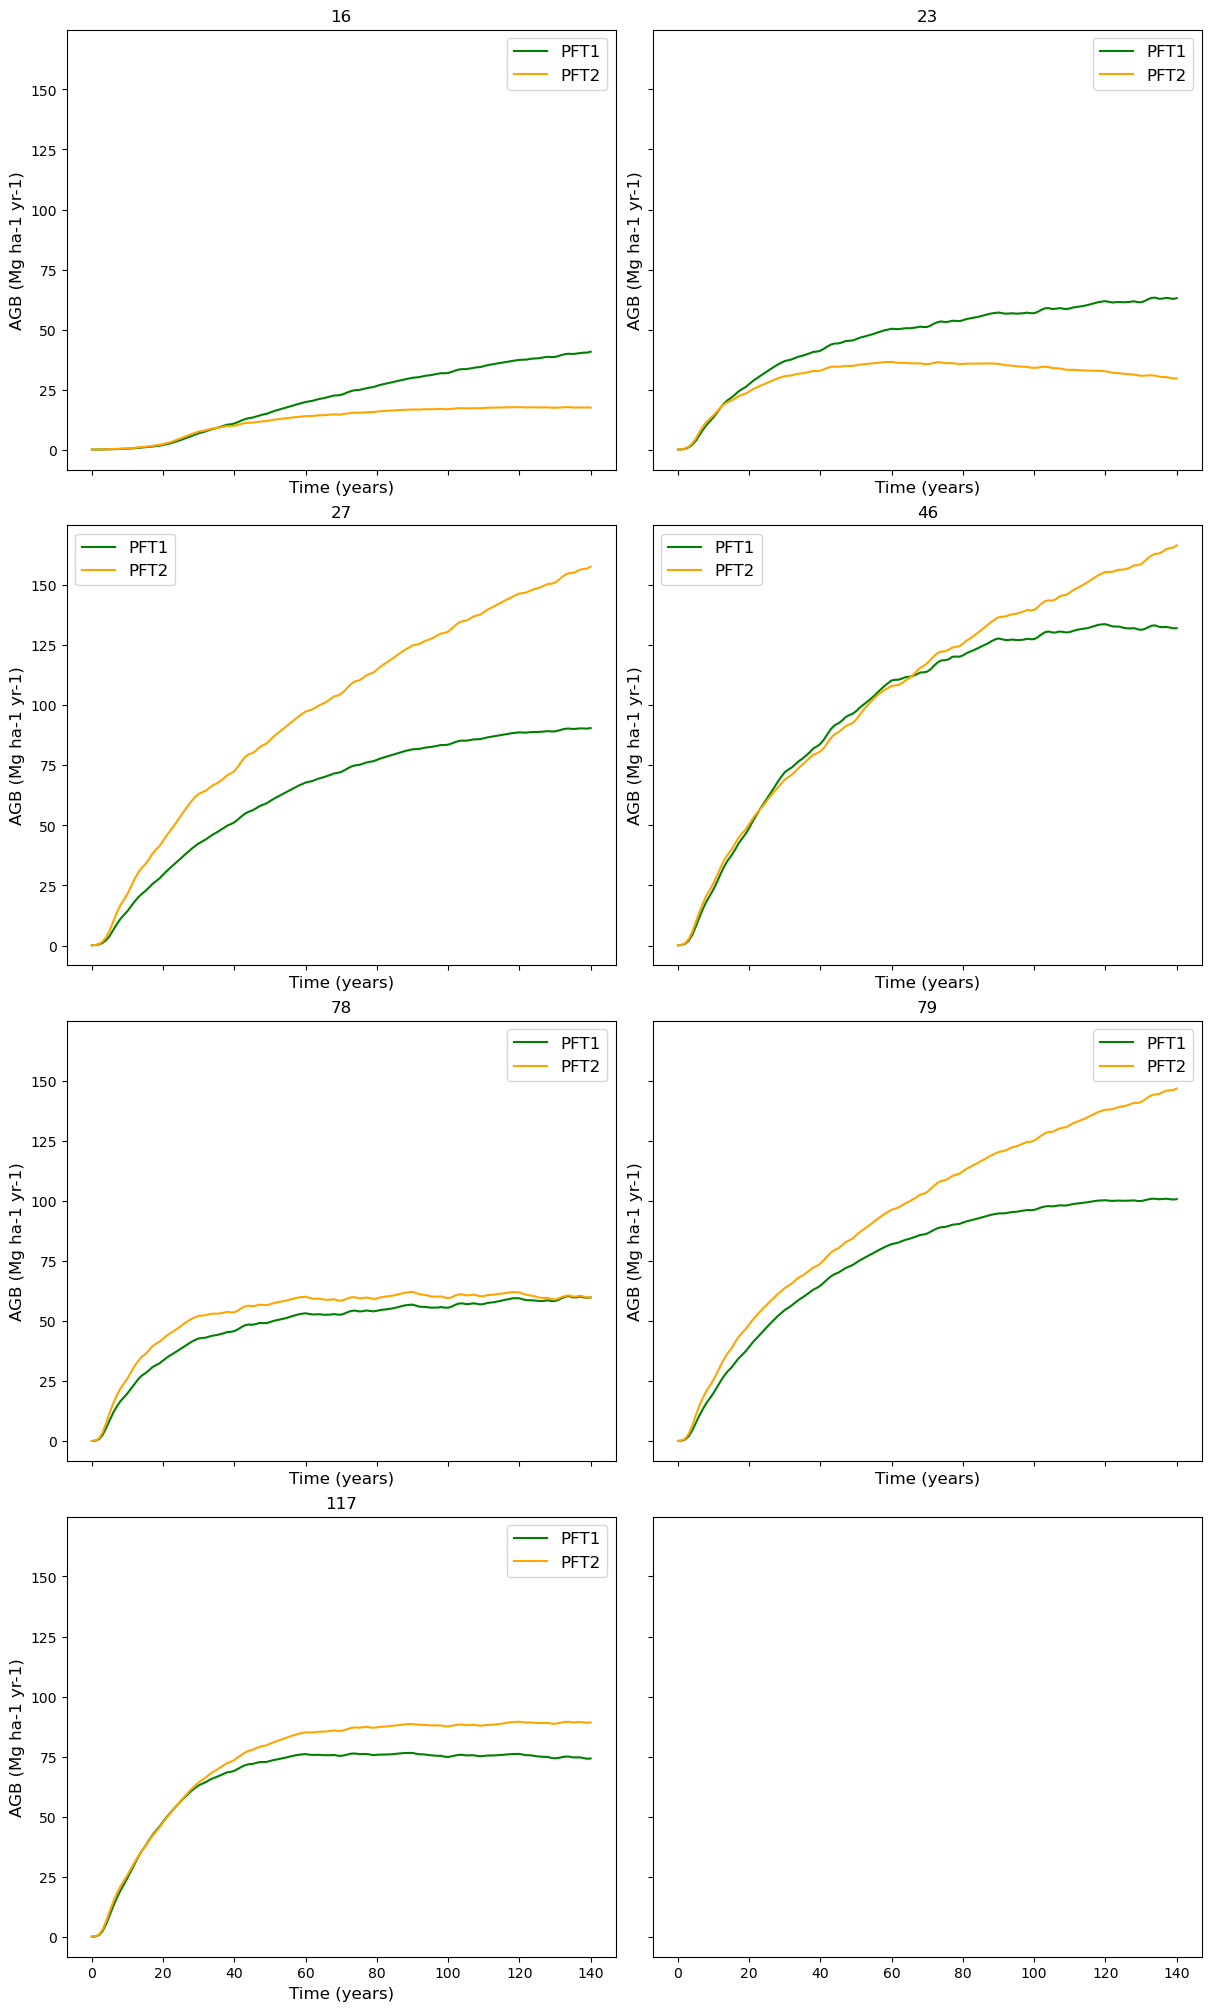

In [40]:
nyears = int(len(bcie.variables['time']))
tave_start = nyears - 10
tave_stop  = nyears

bcie_agb = bcie.FATES_VEGC_PF.isel(time=slice(tave_start, tave_stop)) * (10000 / 1000)
bcie_agb2 = bcie.FATES_VEGC_PF * (10000 / 1000)
#bcie_agb = bcie_agb.mean(dim='time')

bcie_agb_ld = bcie_agb.isel(fates_levpft=0)
bcie_agb_st = bcie_agb.isel(fates_levpft=1)
bcie_agb = np.squeeze(bcie_agb.sum(dim='fates_levpft'))
bcie_agb_ld2 = bcie_agb2.isel(fates_levpft=0)
bcie_agb_st2 = bcie_agb2.isel(fates_levpft=1)

print(bcie_agb_ld[0,0]/bcie_agb[0])

fig1, axs = plt.subplots(nrows=4,ncols=2, figsize=(12,20), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

j = 0
for i in range(0,149):
    if (bcie_agb_ld[i,0:].mean(dim='time')/bcie_agb[i].mean(dim='time')) > 0.3 and (bcie_agb_ld[i,:].mean(dim='time')/bcie_agb[i].mean(dim='time')) < 0.7:
        axs[j].plot(bcietime, bcie_agb_ld2[i,:],label = 'PFT1', color='green')  
        axs[j].plot(bcietime, bcie_agb_st2[i,:], label = 'PFT2', color='orange')
        axs[j].set_title(i)
        axs[j].set_xlabel(r'Time (years)', fontsize=12)
        axs[j].set_ylabel(r'AGB (Mg ha-1 yr-1)', fontsize=12)
        axs[j].legend(prop={'size':12})
        j+=1